In [3]:
import os
# Tắt hoàn toàn XLA để tránh lỗi libdevice
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir="C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8"'
import tensorflow as tf
from tensorflow.python.compiler.xla import xla  # force-disable JIT
tf.config.optimizer.set_jit(False)
import numpy as np
from sklearn.utils import class_weight
import time

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import os

# from keras.applications.imagenet_utils import decode_predictions

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import tensorflow as tf
#tf.config.optimizer.set_jit(True)


IM_SIZE = (224,224)
snore_classes=['bad', 'good']

with open('labelmap.txt', 'w') as f:
  f.write('bad\n')
  f.write('good')

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20, horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(os.path.join(os.getcwd(), 'dataset/train'),
                                                  classes=snore_classes,
                                                  target_size=IM_SIZE,
                                                  class_mode='categorical', shuffle=True,
                                                  batch_size=16)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(os.path.join(os.getcwd(), 'dataset/valid'),
                                                  classes=snore_classes,
                                                  target_size=IM_SIZE,
                                                  class_mode='categorical', shuffle=True,
                                                  batch_size=16)

Found 6858 images belonging to 2 classes.
Found 1361 images belonging to 2 classes.


In [8]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class nr ',idx,' -> ', cls)
print('****************')

os.makedirs(os.path.join(os.getcwd(), 'models'), exist_ok=True)

ModelCheck = ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'models/mobilenet.weights.h5'),
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch'  # Thay thế cho 'period=1'
)

ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=3e-4)

net = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(224,224,3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax', name='softmax')(x)  #class in label
net_final = Model(inputs=net.input, outputs=output_layer)
net_final.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

****************
Class nr  0  ->  bad
Class nr  1  ->  good
****************


Epoch 1/100
428/428 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.6177   
Epoch 1: val_accuracy improved from -inf to 0.67132, saving model to models\best_model.h5
428/428 [==============================] - 60s 131ms/step - loss: 0.2178 - accuracy: 0.6177 - val_loss: 0.2220 - val_accuracy: 0.6713 - lr: 5.0000e-05
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.6673  
Epoch 2: val_accuracy improved from 0.67132 to 0.76397, saving model to models\best_model.h5
428/428 [==============================] - 56s 131ms/step - loss: 0.1170 - accuracy: 0.6673 - val_loss: 0.1214 - val_accuracy: 0.7640 - lr: 5.0000e-05
Epoch 3/100
428/428 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.6942  
Epoch 3: val_accuracy improved from 0.76397 to 0.80441, saving model to models\best_model.h5
428/428 [==============================] - 56s 130ms/step - loss: 0.0752 - accuracy: 0.6942 - val_loss: 0.0677 - val_accurac

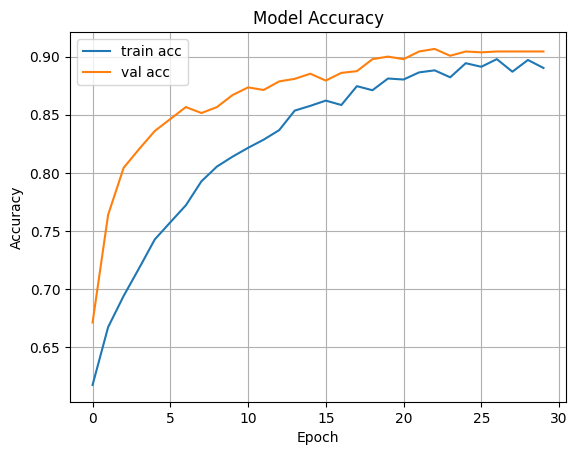

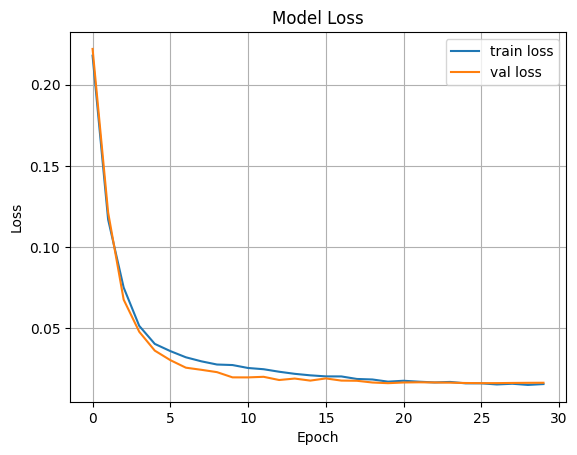

📁 Đã lưu thông số huấn luyện tại: models/training_log.csv


In [5]:
import numpy as np
import time
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# ✅ Focal Loss cho phân loại nhị phân
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# 👉 Tính class weights để xử lý mất cân bằng (vẫn giữ)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_batches.classes),
    y=train_batches.classes
)
class_weights = {i: class_weights_array[i] for i in range(len(np.unique(train_batches.classes)))}

# 👉 Callback: lưu mô hình tốt nhất
model_checkpoint = ModelCheckpoint(
    filepath='models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 👉 Compile lại mô hình với focal loss
net_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# 👉 steps
steps_per_epoch = train_batches.samples // train_batches.batch_size
validation_steps = valid_batches.samples // valid_batches.batch_size

# ✅ Huấn luyện
time1 = time.time()
history = net_final.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[model_checkpoint, reduce_lr, early_stop],
    verbose=1
)
print("⏱️ Thời gian huấn luyện:", round(time.time() - time1, 2), "giây")

# 📈 Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 📉 Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 📝 Lưu lại log CSV
history_df = pd.DataFrame(history.history)
history_csv_path = "models/training_log.csv"
history_df.to_csv(history_csv_path, index=False)
print(f"📁 Đã lưu thông số huấn luyện tại: {history_csv_path}")


Epoch 1/100
428/428 [==============================] - ETA: 0s - loss: 1.0488 - accuracy: 0.6386   
Epoch 1: val_accuracy improved from -inf to 0.73750, saving model to models\best_model.h5
428/428 [==============================] - 74s 166ms/step - loss: 1.0488 - accuracy: 0.6386 - val_loss: 0.8245 - val_accuracy: 0.7375 - lr: 5.0000e-05
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.7121  
Epoch 2: val_accuracy improved from 0.73750 to 0.77794, saving model to models\best_model.h5
428/428 [==============================] - 56s 130ms/step - loss: 0.7217 - accuracy: 0.7121 - val_loss: 0.6995 - val_accuracy: 0.7779 - lr: 5.0000e-05
Epoch 3/100
428/428 [==============================] - ETA: 0s - loss: 0.6004 - accuracy: 0.7414  
Epoch 3: val_accuracy improved from 0.77794 to 0.79559, saving model to models\best_model.h5
428/428 [==============================] - 56s 131ms/step - loss: 0.6004 - accuracy: 0.7414 - val_loss: 0.6576 - val_accurac

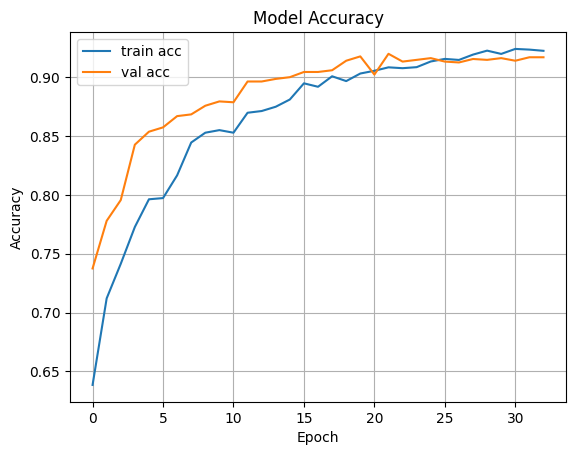

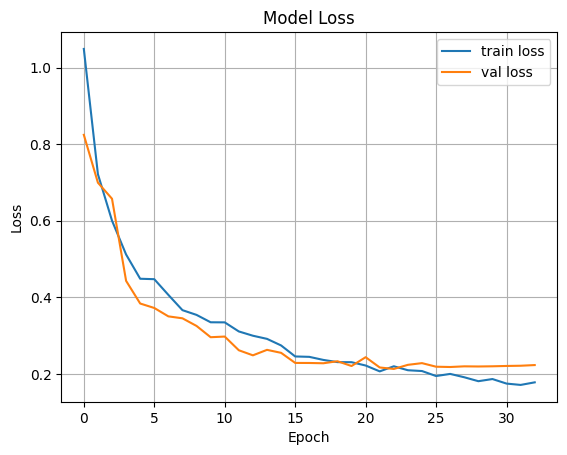

In [3]:
import numpy as np
import time
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# 👉 Tính class weights để xử lý mất cân bằng
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_batches.classes),
    y=train_batches.classes
)
class_weights = {i: class_weights_array[i] for i in range(len(np.unique(train_batches.classes)))}

# 👉 Callback: lưu mô hình tốt nhất dựa trên val_accuracy
model_checkpoint = ModelCheckpoint(
    filepath='models/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 👉 Callback: giảm learning rate khi val_loss không cải thiện
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# 👉 Callback: dừng sớm nếu mô hình không cải thiện sau X epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 👉 Tự động tính steps_per_epoch phù hợp
steps_per_epoch = train_batches.samples // train_batches.batch_size
validation_steps = valid_batches.samples // valid_batches.batch_size

# ✅ Huấn luyện mô hình
time1 = time.time()
history = net_final.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[model_checkpoint, reduce_lr, early_stop],
    verbose=1
)
print("Thời gian huấn luyện:", round(time.time() - time1, 2), "giây")

# 📈 Vẽ biểu đồ chính xác (accuracy)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# 📉 Vẽ biểu đồ mất mát (loss)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd

# 📝 Lưu toàn bộ lịch sử huấn luyện vào CSV
history_df = pd.DataFrame(history.history)
history_csv_path = "models/training_log.csv"
history_df.to_csv(history_csv_path, index=False)

print(f"📁 Đã lưu thông số huấn luyện tại: {history_csv_path}")

📁 Đã lưu thông số huấn luyện tại: models/training_log.csv


86/86 [==============================] - 4s 37ms/step
Classification Report:
              precision    recall  f1-score   support

         bad       0.46      0.43      0.44       615
        good       0.55      0.58      0.57       746

    accuracy                           0.51      1361
   macro avg       0.50      0.50      0.50      1361
weighted avg       0.51      0.51      0.51      1361



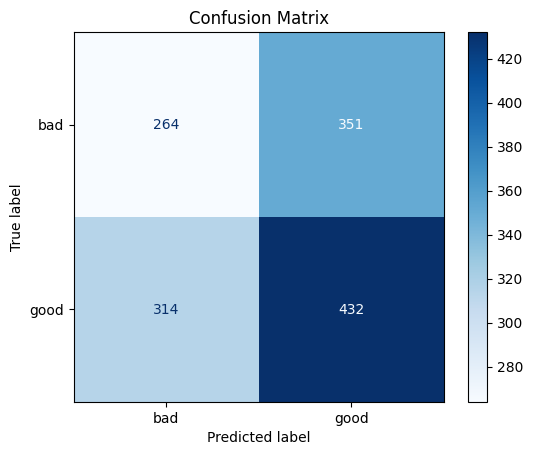

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 🔁 Load lại mô hình tốt nhất
#model = load_model('models/best_model.h5')
model = load_model(
    'models/best_model.h5',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)}
)
# ✅ Dự đoán nhãn cho tập validation
valid_batches.reset()
preds = model.predict(valid_batches, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = valid_batches.classes

# 📊 In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=valid_batches.class_indices.keys()))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [ ]:
import os
import json
import shutil

# Cấu hình đường dẫn
image_dir = r"C:\Users\PC\Downloads\1\train"  # nơi chứa ảnh từ Roboflow
json_path = r"C:\Users\PC\Downloads\1\train\_annotations.coco.json"  # file nhãn từ Roboflow
output_dir = r"C:\Users\PC\Downloads\1\s"

# Tạo thư mục đầu ra nếu chưa có
os.makedirs(output_dir, exist_ok=True)

# Đọc file JSON (dạng COCO)
with open(json_path) as f:
    data = json.load(f)

# Tạo ánh xạ id class → tên class
id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# Tạo ánh xạ ảnh → class (dựa vào annotation)
image_class_map = {}
for ann in data['annotations']:
    image_id = ann['image_id']
    class_id = ann['category_id']
    image_info = next((img for img in data['images'] if img['id'] == image_id), None)
    if image_info:
        filename = image_info['file_name']
        class_name = id_to_name[class_id]
        image_class_map[filename] = class_name

# Di chuyển ảnh về đúng thư mục class
for filename, class_name in image_class_map.items():
    src_path = os.path.join(image_dir, filename)
    class_folder = os.path.join(output_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)
    dst_path = os.path.join(class_folder, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        print(f"✓ {filename} → {class_name}/")
    else:
        print(f"⚠️ Ảnh không tồn tại: {src_path}")

print("✅ Hoàn tất phân chia ảnh.")

# Đường dẫn đến thư mục chứa các class

# Duyệt qua từng thư mục con (mỗi class)
for class_name in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"📁 Class '{class_name}': {image_count} ảnh")



In [49]:
import os
import shutil
import random

# Đường dẫn chứa thư mục 'train/good' và 'train/bad'
original_data_dir = "train"
output_base_dir = "dataset"

# Tỷ lệ chia
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

# Đảm bảo có thư mục đầu ra
splits = ['train', 'valid', 'test']
class_names = os.listdir(original_data_dir)

for split in splits:
    for class_name in class_names:
        split_dir = os.path.join(output_base_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)

# Chia từng class
for class_name in class_names:
    class_dir = os.path.join(original_data_dir, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    valid_end = train_end + int(total * valid_ratio)

    train_files = images[:train_end]
    valid_files = images[train_end:valid_end]
    test_files = images[valid_end:]

    def copy_files(file_list, split):
        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(output_base_dir, split, class_name, file)
            shutil.copy(src, dst)

    copy_files(train_files, 'train')
    copy_files(valid_files, 'valid')
    copy_files(test_files, 'test')

print("\n📦 Số lượng ảnh trong từng tập:")
for split in splits:
    print(f"\n📂 {split.upper()}:")
    for class_name in class_names:
        path = os.path.join(output_base_dir, split, class_name)
        count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  - {class_name}: {count} ảnh")


📦 Số lượng ảnh trong từng tập:

📂 TRAIN:
  - bad: 3112 ảnh
  - good: 3746 ảnh

📂 VALID:
  - bad: 615 ảnh
  - good: 746 ảnh

📂 TEST:
  - bad: 620 ảnh
  - good: 747 ảnh
